In [136]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import tt_ind_solve_power
import matplotlib.pyplot as plt
import math
from scipy import stats

In [137]:
# user choice
daily_ss_per_group = 1000
baseline_conversion_rate = 0.2
abs_or_rel_effect = 'absolute' # 'absolute' or 'relative'

# fixed parameters
power = 0.8
confidence_level = 0.95
max_lim_days = 90

## Statsmodel function (Cohen)

In [138]:
def compute_cumulative_ss(daily_ss_per_group: int, max_lim_days: int) -> list:
    return np.cumsum([daily_ss_per_group] * max_lim_days)

def compute_absolute_effect_size(l_ss_per_group: list, alpha: float, power: float) -> list:
    return [tt_ind_solve_power(nobs1 = ss,
                               alpha = alpha,
                               power = power,
                               ratio = 1,
                               alternative = 'two-sided') for ss in l_ss_per_group]

def compute_relative_effect_size(l_absolute_effect_size: list, baseline_conversion_rate: float) -> list:
    return [x / baseline_conversion_rate for x in l_absolute_effect_size]

def plot_cumulative_mde(l_days: list, 
                        l_absolute_effect_size: list, 
                        baseline_conversion_rate: float,
                        abs_or_rel_effect='absolute'):
    
    if abs_or_rel_effect=='relative':
        l_effect_size = compute_relative_effect_size(l_absolute_effect_size, baseline_conversion_rate)
    else:
        l_effect_size = l_absolute_effect_size
        
    plt.plot(l_days, l_effect_size)
    plt.title(f'''What is the Minimum Detectable Effect I can expect after X days 
              and a baseline conversion rate of {round(baseline_conversion_rate * 100)}%?''')
    plt.xlabel("Days")
    if abs_or_rel_effect=='relative':
        plt.ylabel("Relative effect size")
    else:
        plt.ylabel("Absolute effect size")
        
    l_x_y = []
    for x, y in zip(l_days, l_effect_size):
        l_x_y.append((x, y))
    coordinates = [l_x_y[i] for i in np.arange(0, len(l_days), 10)]
    
    for couple in coordinates:
        label = str(round(couple[1] * 100, 1)) + '%'
        plt.annotate(label,
                     couple,
                     textcoords='offset points',
                     xytext=(0, 2),
                     ha='left')
    plt.show()

/Users/agathelaemmel/Documents/GitHub/perso/action-xp-time/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/agathelaemmel/Documents/GitHub/perso/action-xp-time/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


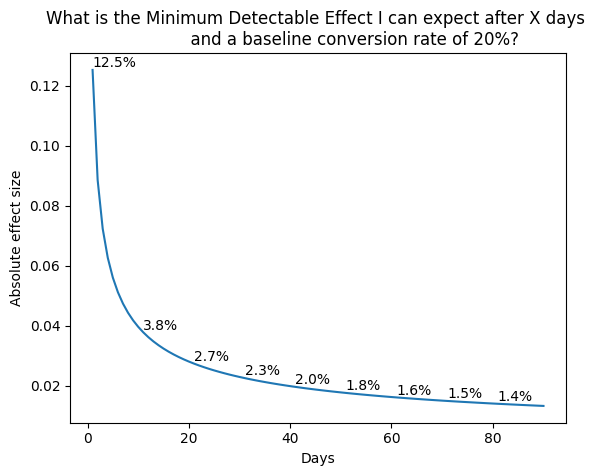

In [139]:
l_days = list(range(1, max_lim_days + 1))
l_ss_per_group = compute_cumulative_ss(daily_ss_per_group, max_lim_days)
# effect_size = uplift divided by the standard deviation 
l_absolute_effect_size = compute_absolute_effect_size(l_ss_per_group=l_ss_per_group, 
                                                      alpha=1-confidence_level, 
                                                      power=power)
plot_cumulative_mde(l_days, l_absolute_effect_size, baseline_conversion_rate, abs_or_rel_effect)

## power.prop.test in R

In [140]:
tt_ind_solve_power(nobs1 = 17437,
                   alpha = 0.05,
                   power = 0.8,
                   ratio = 1,
                   alternative = 'two-sided')
# different in R because we can add p1 and we don't look at effect size

0.030005097860393157

In [141]:
p1 = 0.5
delta = 0.01
alpha = 0.05
power = 0.8
# in R, n = 39240

In [142]:
def compute_sample_size(p1: float, delta: float, alpha: float, beta: float) -> int:
    z_alpha = stats.norm.ppf(alpha / 2, loc=0, scale=1)
    z_beta = stats.norm.ppf(beta, loc=0, scale=1)
    
    p2 = p1 + delta
    p_avg = (p1 + p2) / 2
    
    left = z_alpha * math.sqrt(2 * p_avg * (1- p_avg))
    right = z_beta * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))
    numerator = (left + right) ** 2
    
    n = numerator / (delta ** 2)
    
    return int(math.ceil(n))

In [143]:
n = compute_sample_size(p1=p1, alpha=alpha, beta=1-power, delta=delta)
n

39240

In [144]:
def compute_delta(p1: float, n: int, alpha: float, beta: float) -> float:
    z_alpha = stats.norm.ppf(alpha / 2, loc=0, scale=1)
    z_beta = stats.norm.ppf(beta, loc=0, scale=1)
    z = (z_alpha + z_beta) ** 2
    
    p = 2 * p1 * (1 - p1) / n
    delta = math.sqrt(z * p)
    
    return round(delta, 3)

In [145]:
compute_delta(p1=p1, n=n, alpha=alpha, beta=1-power)

0.01

In [146]:
p1 = 0.2
delta = 0.01
alpha = 0.05
power = 0.8
# in R, n = 25583

In [147]:
n = compute_sample_size(p1=p1, alpha=alpha, beta=1-power, delta=delta)
n

25583

In [148]:
compute_delta(p1=p1, n=n, alpha=alpha, beta=1-power)

0.01

In [149]:
def compute_cumulative_ss(daily_ss_per_group: int, max_lim_days: int) -> list:
    return np.cumsum([daily_ss_per_group] * max_lim_days)

def compute_absolute_delta(l_ss_per_group: list, 
                           baseline_conversion_rate: float,
                           confidence_level: float, 
                           power: float) -> list:
    return [compute_delta(p1=baseline_conversion_rate,
                          n=ss,
                          alpha=1-confidence_level,
                          beta=1-power) for ss in l_ss_per_group]

def compute_relative_delta(l_absolute_delta: list, baseline_conversion_rate: float) -> list:
    return [x / baseline_conversion_rate for x in l_absolute_delta]

def plot_cumulative_mde(l_days: list, 
                        l_absolute_delta: list, 
                        l_relative_delta: list,
                        abs_or_rel_effect='absolute'):
    
    if abs_or_rel_effect=='relative':
        l_delta = l_relative_delta
    else:
        l_delta = l_absolute_delta
        
    plt.plot(l_days, l_delta)
    plt.title(f'''What is the Minimum Detectable Effect I can expect after X days 
              and a baseline conversion rate of {round(baseline_conversion_rate * 100)}%?''')
    plt.xlabel("Days")
    if abs_or_rel_effect=='relative':
        plt.ylabel("Relative Uplift")
    else:
        plt.ylabel("Absolute Uplift")
        
    l_x_y = []
    for x, y in zip(l_days, l_delta):
        l_x_y.append((x, y))
    coordinates = [l_x_y[i] for i in np.arange(0, len(l_days), 10)]
    
    for couple in coordinates:
        label = str(round(couple[1] * 100, 1)) + '%'
        plt.annotate(label,
                     couple,
                     textcoords='offset points',
                     xytext=(0, 2),
                     ha='left')
    plt.show()

In [150]:
# user choice
daily_ss_per_group = 1000
baseline_conversion_rate = 0.2
abs_or_rel_effect = 'absolute' # 'absolute' or 'relative'

# fixed parameters
power = 0.8
confidence_level = 0.95
max_lim_days = 90

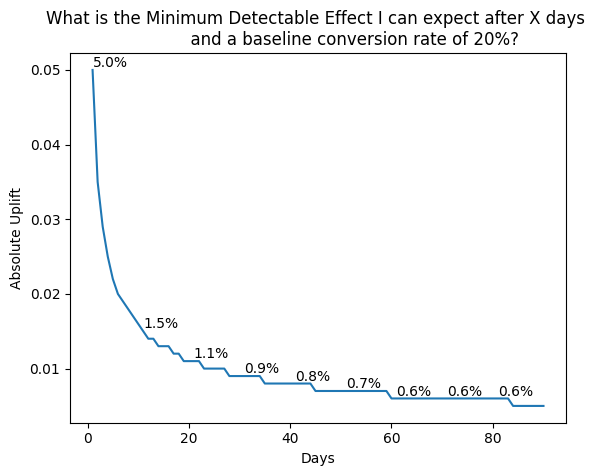

In [151]:
l_days = list(range(1, max_lim_days + 1))
l_ss_per_group = compute_cumulative_ss(daily_ss_per_group, max_lim_days)
l_absolute_delta = compute_absolute_delta(l_ss_per_group=l_ss_per_group, 
                                          baseline_conversion_rate=baseline_conversion_rate,
                                          confidence_level=confidence_level,
                                          power=power)
l_relative_delta = compute_relative_delta(l_absolute_delta, baseline_conversion_rate)
                                                
plot_cumulative_mde(l_days, l_absolute_delta, l_relative_delta, abs_or_rel_effect)